## Ejecutar el DAG creado

In [82]:
import requests
from requests.auth import HTTPBasicAuth

# Configura la URL de la API de Airflow y las credenciales
airflow_url = "http://localhost:8080/api/v1"
dag_id = "etl"
auth = HTTPBasicAuth('airflow', 'airflow')

# Despausar el DAG
unpause_dag_url = f"{airflow_url}/dags/{dag_id}"
response = requests.patch(unpause_dag_url, json={"is_paused": False}, auth=auth)

if response.status_code == 200:
    print(f"DAG '{dag_id}' activado correctamente.")
else:
    print(f"Error al activar el DAG: {response.text}")

# Ejecutar el DAG manualmente
trigger_dag_url = f"{airflow_url}/dags/{dag_id}/dagRuns"
response = requests.post(trigger_dag_url, json={}, auth=auth)

if response.status_code == 200:
    print(f"DAG '{dag_id}' ejecutado correctamente.")
else:
    print(f"Error al ejecutar el DAG: {response.text}")

DAG 'etl' activado correctamente.
DAG 'etl' ejecutado correctamente.


Se recomienda esperar un minuto para que el DAG pueda terminar de ejecutarse.

## MODELO TP1 para MLFLOW

### Librerias

In [83]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import datetime
import mlflow
from mlflow.tracking import MlflowClient

from sqlalchemy import create_engine
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import boto3
from botocore.client import Config



### Variables de entorno y conexión con MlFlow

In [84]:
os.environ['AWS_ACCESS_KEY_ID'] = 'minio'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'minio123'
os.environ['ENDPOINT_URL'] = 'http://localhost:9001'
os.environ["MLFLOW_S3_ENDPOINT_URL"] = 'http://localhost:9000'
os.environ["AWS_ENDPOINT_URL_S3"] = 'http://localhost:9001'

#mlflow.end_run()
mlflow.set_tracking_uri('http://localhost:5005')

experiment_name = "precio_propiedades_model_experiment"

if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(name=experiment_name)

experiment = mlflow.get_experiment_by_name(experiment_name)

# Obtener las variables de entorno (puedes ajustarlas según sea necesario)
pg_user = os.getenv('PG_USER', 'airflow')
pg_password = os.getenv('PG_PASSWORD', 'airflow')
pg_host = 'localhost'  # Si estás ejecutando el script desde dentro del contenedor, usa 'postgres'
pg_port = os.getenv('PG_PORT', '5432')
pg_database = os.getenv('PG_DATABASE', 'airflow')

db_url = f'postgresql+psycopg2://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_database}'

# Crear la conexión con SQLAlchemy
engine = create_engine(db_url)

### Lectura de DB

Obtengo de la DB Postgre el dataset de entrenamiento-testeo ya procesado y escalado desde Airflow

In [85]:
# Leer los datos para entrenar el modelo
query = 'SELECT * FROM public."X_train_scaled";'
X_train = pd.read_sql(query, engine)
X_train[X_train.select_dtypes(['bool']).columns] = X_train.select_dtypes(['bool']).astype(int)

query = 'SELECT * FROM public."X_test_scaled";'
X_test = pd.read_sql(query, engine)
X_test[X_test.select_dtypes(['bool']).columns] = X_test.select_dtypes(['bool']).astype(int)

query = 'SELECT * FROM public."y_train_scaled";'
y_train = pd.read_sql(query, engine)
y_train[y_train.select_dtypes(['bool']).columns] = y_train.select_dtypes(['bool']).astype(int)

query = 'SELECT * FROM public."y_test_scaled";'
y_test = pd.read_sql(query, engine)
y_test[y_test.select_dtypes(['bool']).columns] = y_test.select_dtypes(['bool']).astype(int)

### Elección y entrenamiento de Modelo
USamos Regresor XGBOOST del TP1. Cargamos el expermiento en ML con la carga del modelo como artefacto, las métricas asociadas y el gráfico de featrues con mayor importancia

In [86]:

def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

In [87]:
# Creemos el experimento
experiment_id = get_or_create_experiment("Precio Propiedades")
print(experiment_id)

run_name_parent = "best_hyperparam_"  + datetime.datetime.today().strftime('%Y/%m/%d-%H:%M:%S"')

2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   expenses_amount  8154 non-null   float64
 1   total_mts        8154 non-null   float64
 2   covered_mts      8154 non-null   float64
 3   rooms            8154 non-null   float64
 4   bedrooms         8154 non-null   float64
 5   bathrooms        8154 non-null   float64
 6   garages          8154 non-null   float64
 7   antique          8154 non-null   float64
dtypes: float64(8)
memory usage: 509.8 KB
None

Desempeño en el conjunto de prueba:
MAE: 0.3302090861391858
MSE: 0.27860693809655074
RMSE: 0.5278323011113953
R²: 0.7241861820220947


2025/08/09 12:23:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/09 12:23:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'precio_propiedades_model_dev' already exists. Creating a new version of this model...
2025/08/09 12:23:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: precio_propiedades_model_dev, version 3
Created version '3' of model 'precio_propiedades_model_dev'.


🏃 View run nimble-hog-675 at: http://localhost:5005/#/experiments/1/runs/9cccee1281514c738880fa99a9497ba3
🧪 View experiment at: http://localhost:5005/#/experiments/1
Finalizado


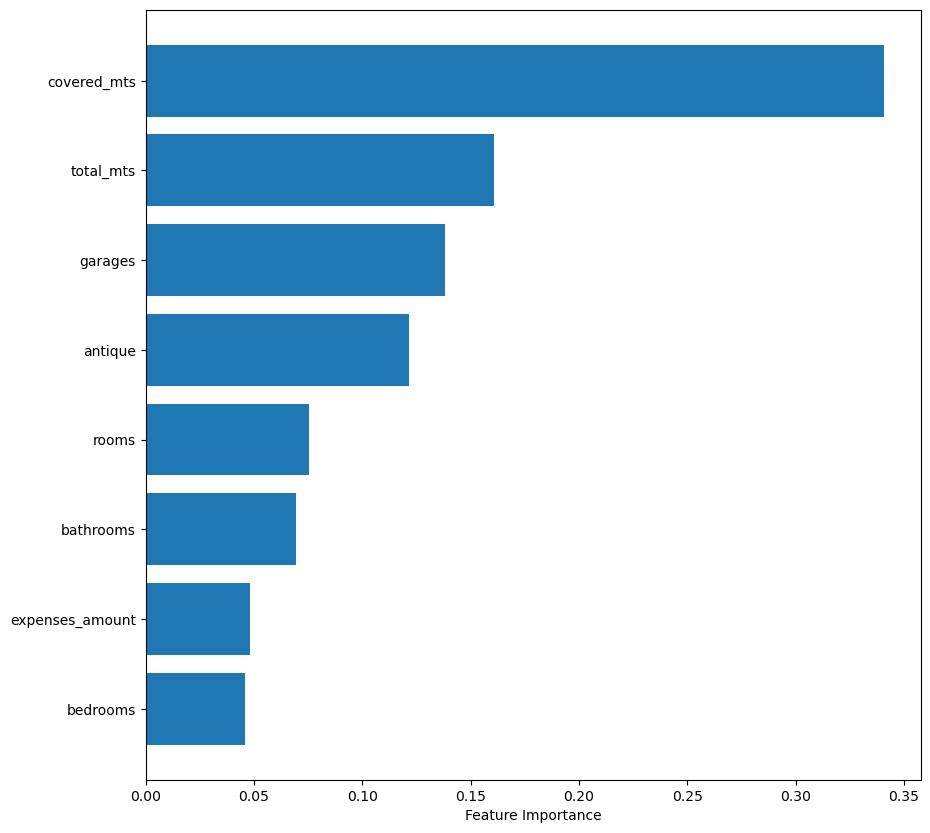

In [88]:
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, enable_categorical=True)
print(X_train.info())
xgb_regressor.fit(X_train, y_train)

artifact_path='xgb_model'
model_uri = ""
model_version = 1

with mlflow.start_run(experiment_id = experiment.experiment_id):
    # Se registran los mejores hiperparámetros
    mlflow.log_params(xgb_regressor.get_params())
    
    # Se obtiene las predicciones del dataset de evaluación
    y_pred = xgb_regressor.predict(X_test)
    # y_test_inversed = scaler_y.inverse_transform(y_test)
    # y_pred_inversed = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
    
    # Se calculan las métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("\nDesempeño en el conjunto de prueba:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")
    
    # Y las enviamos a MLFlow
    metrics ={
        'mae': mae,
        'mse': mse, 
        'rmse': rmse,
        'r2': r2
        }
    mlflow.log_metrics(metrics)
    # Obtenemos la importancia de características
    feature_importances = xgb_regressor.feature_importances_
    feature_names = X_train.columns  # Excluir la columna objetivo

    # Ordenamos los índices
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, 10))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')

    # Guardar el gráfico en un archivo temporal
    plot_filename = 'feature_importances.png'
    plt.savefig(plot_filename)

    # Registrar el gráfico en MLflow
    mlflow.log_figure(plt.gcf(), artifact_file="feature_importances.png")


    # Registramos el modelo y los datos de entrenamiento
    mlflow.sklearn.log_model(
            sk_model=xgb_regressor,
            artifact_path=artifact_path,
            serialization_format='cloudpickle',
            registered_model_name="precio_propiedades_model_dev",
            metadata={"model_data_version": model_version}
            )

   
    # Obtenemos la ubicación del modelo guardado en MLFlow
    model_uri = mlflow.get_artifact_uri(artifact_path)


print('Finalizado')

In [89]:
from mlflow import MlflowClient

client = MlflowClient()
name = "precio_propiedades_model_prod"
desc = "Predice el precio de propiedades en CABA"

# Creamos el modelo productivo
# Chequear si el modelo ya está registrado
registered_models = client.search_registered_models(f"name='{name}'")

if not registered_models:
    client.create_registered_model(name=name, description=desc)



# Guardamos como tag los hiper-parametros en la version del modelo
tags = xgb_regressor.get_params()
tags["model"] = type(xgb_regressor).__name__
tags["mae"] = mae
tags["mse"] = mse
tags["rmse"] = rmse
tags["r2"] = r2

# Guardamos la version del modelo
result = client.create_model_version(
    name=name,
    source=model_uri,
    run_id=model_uri.split("/")[-3],
    tags=tags
)

# Y creamos como la version con el alias de prod para poder levantarlo en nuestro
# proceso de servicio del modelo on-line.
client.set_registered_model_alias(name, "prod", result.version)

2025/08/09 12:23:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: precio_propiedades_model_prod, version 3


In [90]:
def s3_folder_exists(bucket_name, folder_path, endpoint_url=None):
    """
    Check if a folder exists in an S3 bucket.

    Parameters:
    - bucket_name (str): Name of the S3 bucket.
    - folder_path (str): Path to the folder in the bucket (e.g., 'myfolder/').
    - endpoint_url (str, optional): Custom endpoint URL for S3 (e.g., MinIO).

    Returns:
    - bool: True if the folder exists, False otherwise.
    """
    s3 = boto3.client('s3', endpoint_url=endpoint_url, config=Config(signature_version='s3v4'))
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_path, MaxKeys=1)
    return 'Contents' in response

# Ejemplo de uso:
# exists = s3_folder_exists('mi-bucket', 'mi-carpeta/', endpoint_url=os.environ['ENDPOINT_URL'])
# print("Existe la carpeta:", exists)